In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
import torch.nn as nn

In [2]:
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
        'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
        'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
        'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
        'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
        'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
        'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

features_dir = r"audio_features"
labels_dir = r"labels"

In [3]:
ann_df = pd.read_csv( 'annotations.csv')
meta_df = pd.read_csv('metadata.csv')


train_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[:int(len(meta_df)*0.7)]
validation_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[int(len(meta_df)*0.7):int(len(meta_df)*0.9)]
test_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[int(len(meta_df)*0.9):len(meta_df)]





In [4]:
def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        if(sum(frame_labels) == 0):
            __y.append([0])
        elif(np.count_nonzero(frame_labels) == len(frame_labels)):
             __y.append([1])
        else: #The annotators don't agree on the label
            __y.append([np.random.choice(frame_labels)])
    return __y

In [5]:
import itertools
def read_files(file_names):
    X_train = []
    Y_train = {}
    for c in categories:
        Y_train[c] = []
    for f in file_names: #we are not loading the entire dataset due to processing time
        features = np.load(os.path.join(features_dir , f.split('.')[0] + '.npz'))["melspectrogram"]
        X_train.append(features)
        y = np.load(os.path.join(labels_dir , f.split('.')[0] + '_labels.npz'))
        for c in categories:
            _y = aggregate_labels(y[c])
            Y_train[c].extend(list(itertools.chain.from_iterable(_y)))
    X_train = np.concatenate(X_train)
    return X_train, Y_train


In [6]:
train_x,train_y = read_files(train_filename)
val_x, val_y = read_files(validation_filename)
test_x, test_y = read_files(test_filename)

In [7]:
train_x.shape
val_x.shape
test_x.shape
print(f'shape of train set:{train_x.shape}, shape of val set:{val_x.shape}, shape of test set:{test_x.shape}')
#print(f'shape of train_y set:{train_y.shape}, shape of val_y set:{val_y.shape}, shape of test_y set:{test_y.shape}')

shape of train set:(1078243, 64), shape of val set:(305277, 64), shape of test set:(155057, 64)


In [8]:
from sklearn.preprocessing import StandardScaler

def log_scalling(array):
    epsilon = 1e-10  
    log_array = np.log(array + epsilon)
    return log_array
    
def z_score(array):
    s = StandardScaler()
    scaled_array = s.fit_transform(array)
    return scaled_array,s.mean_,s.scale_

In [9]:
log_train_x,log_validation_x,log_test_x = log_scalling(train_x),log_scalling(val_x),log_scalling(test_x)


scaled_train_x,mu,std = z_score(log_train_x)
scaled_validation_x = (log_validation_x - mu)/std
scaled_test_x = (log_test_x - mu)/std

In [10]:
train_y = np.array([train_y[cls] for cls in categories]).T
val_y = np.array([val_y[cls] for cls in categories]).T
test_y = np.array([test_y[cls] for cls in categories]).T
train_y.shape

(1078243, 58)

In [12]:
class SpectrogramTransformer(nn.Module):
    def __init__(self,mel_bin=64,em_dim=128,num_labels=58 , n_head=4 , num_layer=2,dropout=0.3):
        super().__init__()
        self.input_projection = nn.Linear(mel_bin,em_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=em_dim,nhead=n_head,dropout=dropout,batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer,num_layer)
        self.classifier = nn.Linear(em_dim,num_labels)

    def forward(self,x):
        x = self.input_projection(x)
        x = self.transformer(x)
        logits = self.classifier(x)
        return logits

In [35]:
def train_model(model):
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    from torch.nn.functional import sigmoid

    device = "cuda"

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    training_loss = []
    validation_loss = []

    # Datasets
    batch_size = 32
    scaled_train_x_tensor = torch.tensor(scaled_train_x, dtype=torch.float32)
    train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
    scaled_validation_x_tensor = torch.tensor(scaled_validation_x, dtype=torch.float32)
    val_y_tensor = torch.tensor(val_y, dtype=torch.float32)

    train_dataset = TensorDataset(scaled_train_x_tensor, train_y_tensor)
    val_dataset = TensorDataset(scaled_validation_x_tensor, val_y_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    num_epochs = 3

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            preds = (sigmoid(output) > 0.5).int()
            targets = y_batch.int()
            train_correct += (preds == targets).sum().item()
            train_total += targets.numel()

        train_accuracy = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        training_loss.append(avg_train_loss)

        # ----------- Validation and Metrics -----------
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                val_output = model(x_val)
                val_loss += criterion(val_output, y_val).item()

                probs = sigmoid(val_output)
                preds = (probs > 0.5).int()
                targets = y_val.int()

                all_preds.append(preds)
                all_targets.append(targets)

        avg_val_loss = val_loss / len(val_loader)
        validation_loss.append(avg_val_loss)

        # Stack predictions
        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        # Compute metrics
        TP = (all_preds & all_targets).sum(dim=0).float()
        FP = ((all_preds == 1) & (all_targets == 0)).sum(dim=0).float()
        FN = ((all_preds == 0) & (all_targets == 1)).sum(dim=0).float()
        TN = ((all_preds == 0) & (all_targets == 0)).sum(dim=0).float()

        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)
        f1 = (2 * precision * recall) / (precision + recall + 1e-8)
        tnr = TN / (TN + FP + 1e-8)
        balanced_acc = (recall + tnr) / 2

        avg_precision = precision.mean().item()
        avg_recall = recall.mean().item()
        avg_f1 = f1.mean().item()
        avg_bal_acc = balanced_acc.mean().item()
        val_accuracy = (all_preds == all_targets).float().mean().item()

        print(f"\n Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss:                  {avg_train_loss:.4f}")
        print(f"Train Accuracy:              {train_accuracy:.4f}")
        print(f"Val Loss:                    {avg_val_loss:.4f}")
        print(f"Validation Accuracy:         {val_accuracy:.4f}")
        print(f"Precision:                   {avg_precision:.4f}")
        print(f"Recall:                      {avg_recall:.4f}")
        print(f"F1 Score:                    {avg_f1:.4f}")
        print(f"Average Balanced Accuracy:   {avg_bal_acc:.4f}")

    # Save model
    torch.save(model.state_dict(), 'spectrogram_transformer_weights.pth')
    torch.save(model, 'spectrogram_transformer_full_model.pth')

    return training_loss, validation_loss, {
        "precision": avg_precision,
        "recall": avg_recall,
        "f1": avg_f1,
        "balanced_accuracy": avg_bal_acc,
        "val_accuracy": val_accuracy
    }


In [36]:
device = "cuda"
model_32 = SpectrogramTransformer(em_dim=32).to(device)
train_loss_32, val_loss_32, metrics_32 = train_model(model_32)


 Epoch 1/3
Train Loss:                  0.0746
Train Accuracy:              0.9798
Val Loss:                    0.0778
Validation Accuracy:         0.9795
Precision:                   0.3591
Recall:                      0.0663
F1 Score:                    0.0987
Average Balanced Accuracy:   0.5325

 Epoch 2/3
Train Loss:                  0.0676
Train Accuracy:              0.9808
Val Loss:                    0.0786
Validation Accuracy:         0.9793
Precision:                   0.4079
Recall:                      0.0885
F1 Score:                    0.1278
Average Balanced Accuracy:   0.5432

 Epoch 3/3
Train Loss:                  0.0649
Train Accuracy:              0.9813
Val Loss:                    0.0779
Validation Accuracy:         0.9793
Precision:                   0.4135
Recall:                      0.0971
F1 Score:                    0.1403
Average Balanced Accuracy:   0.5474


In [49]:
torch.save(model_32.state_dict(), 'spectrogram_transformer32_weights.pth')
torch.save(model_32, 'spectrogram_transformer32_full_model.pth')


In [41]:
train_loss_32 = [0.0746,0.0676,0.0649]
val_loss_32 = [0.0778,0.0786,0.0779]

In [38]:
model_16 = SpectrogramTransformer(em_dim=16).to(device)
train_loss_16, val_loss_16, metrics_16 = train_model(model_16)


 Epoch 1/3
Train Loss:                  0.0781
Train Accuracy:              0.9794
Val Loss:                    0.0789
Validation Accuracy:         0.9795
Precision:                   0.2199
Recall:                      0.0322
F1 Score:                    0.0498
Average Balanced Accuracy:   0.5158

 Epoch 2/3
Train Loss:                  0.0729
Train Accuracy:              0.9800
Val Loss:                    0.0782
Validation Accuracy:         0.9796
Precision:                   0.3324
Recall:                      0.0492
F1 Score:                    0.0740
Average Balanced Accuracy:   0.5241

 Epoch 3/3
Train Loss:                  0.0715
Train Accuracy:              0.9802
Val Loss:                    0.0788
Validation Accuracy:         0.9794
Precision:                   0.3560
Recall:                      0.0661
F1 Score:                    0.0997
Average Balanced Accuracy:   0.5323


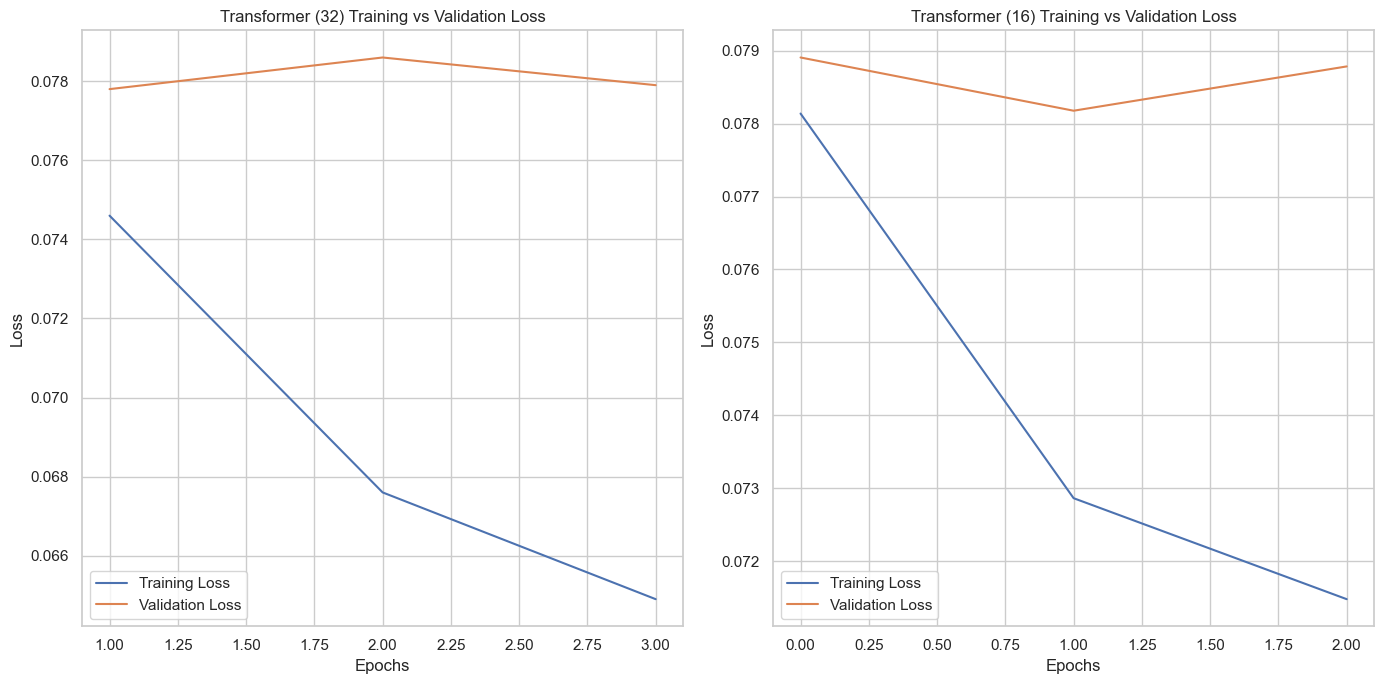

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

epochs = 6
# Transformer 32
ax[0].plot(range(1,3+1,1), train_loss_32, label="Training Loss")
ax[0].plot(range(1,3+1,1), val_loss_32, label="Validation Loss")
ax[0].set_title("Transformer (32) Training vs Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Transformer `6
ax[1].plot(range(3), train_loss_16, label="Training Loss")
ax[1].plot(range(3), val_loss_16, label="Validation Loss")
ax[1].set_title("Transformer (16) Training vs Validation Loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend()

plt.tight_layout()
plt.show()


In [46]:
def evaluate_model_on_test_set(model):
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    from torch.nn.functional import sigmoid

    # Prepare test data
    scaled_test_x_tensor = torch.tensor(scaled_test_x, dtype=torch.float32)
    test_y_tensor = torch.tensor(test_y, dtype=torch.float32)
    test_dataset = TensorDataset(scaled_test_x_tensor, test_y_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32)

    model.eval()
    criterion = nn.BCEWithLogitsLoss()
    test_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.to(device).float()
            y_test = y_test.to(device).float()

            output = model(x_test)
            test_loss += criterion(output, y_test).item()

            probs = sigmoid(output)
            preds = (probs > 0.5).int()
            targets = y_test.int()

            all_preds.append(preds)
            all_targets.append(targets)

    # Concatenate predictions
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute metrics
    TP = (all_preds & all_targets).sum(dim=0).float()
    FP = ((all_preds == 1) & (all_targets == 0)).sum(dim=0).float()
    FN = ((all_preds == 0) & (all_targets == 1)).sum(dim=0).float()
    TN = ((all_preds == 0) & (all_targets == 0)).sum(dim=0).float()

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = (2 * precision * recall) / (precision + recall + 1e-8)
    tnr = TN / (TN + FP + 1e-8)
    balanced_acc = (recall + tnr) / 2

    avg_precision = precision.mean().item()
    avg_recall = recall.mean().item()
    avg_f1 = f1.mean().item()
    avg_bal_acc = balanced_acc.mean().item()
    exact_match_accuracy = (all_preds == all_targets).float().mean().item()
    avg_test_loss = test_loss / len(test_loader)

    # Print metrics
    print("\n📊 Test Set Evaluation")
    print(f"Test Loss:                 {avg_test_loss:.4f}")
    print(f"Test Accuracy:             {exact_match_accuracy * 100:.2f}%")
    print(f"Precision (macro):         {avg_precision * 100:.2f}%")
    print(f"Recall (macro):            {avg_recall * 100:.2f}%")
    print(f"F1 Score (macro):          {avg_f1 * 100:.2f}%")
    print(f"Balanced Accuracy (macro):{avg_bal_acc * 100:.2f}%")

    return {
        "test_loss": avg_test_loss,
        "accuracy": exact_match_accuracy,
        "precision": avg_precision,
        "recall": avg_recall,
        "f1": avg_f1,
        "balanced_accuracy": avg_bal_acc
    }


In [47]:
metrics_test = evaluate_model_on_test_set(model_16)


📊 Test Set Evaluation
Test Loss:                 0.0809
Test Accuracy:             97.90%
Precision (macro):         30.33%
Recall (macro):            5.92%
F1 Score (macro):          8.69%
Balanced Accuracy (macro):52.88%


In [48]:
metrics_test_32 = evaluate_model_on_test_set(model_32)


📊 Test Set Evaluation
Test Loss:                 0.0807
Test Accuracy:             97.87%
Precision (macro):         32.45%
Recall (macro):            8.20%
F1 Score (macro):          11.70%
Balanced Accuracy (macro):53.99%
